In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

torch.manual_seed(1)

import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import seaborn as sns
import scipy.io as sio
from matplotlib import rc

def set_style_sns():
    sns.set_context('paper')
    sns.set(font = 'serif')
    sns.set(font_scale = 1.3)
    
    sns.set_style('white', {
        'font.family': 'serif',
        'font.serif': ['Time', 'Palatino', 'serif'],
        'lines.markersize': 10
    })
    
    
plt.rcParams.update({'font.size':16})
set_style_sns()

plt.rcParams.update({'text.usetex': False})

In [2]:
data = sio.matlab.loadmat('./../data/ece271b_data_select.mat')

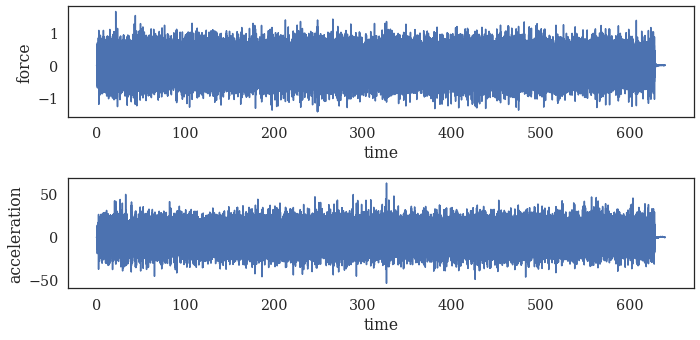

In [3]:
u = np.array(data['u'])
y = np.array(data['y'])
t = np.array(data['time'])[:,0]
plt.figure(figsize=(10,5))
plt.subplot(2,1,1)
plt.plot(t,u)
plt.xlabel('time')
plt.ylabel('force')

plt.subplot(2,1,2)
plt.plot(t,y)
plt.xlabel('time')
plt.ylabel('acceleration')

plt.tight_layout()
plt.show()

In [35]:
umax = np.max(u)
ymax = np.max(y)

u_norm = u/umax
y_norm = y/ymax

N = len(u)
ntrain = int(N*0.01)
start = 100

print(ntrain)
utrain = u_norm[start:ntrain]
ytrain = y_norm[start:ntrain]
ttrain = t[start:ntrain]
intrain = np.hstack([utrain,ytrain])

utest = u_norm[ntrain:start+ntrain+500]
ytest = y_norm[ntrain:start+ntrain+500]
ttest = t[ntrain:start+ntrain+500]
intest = np.hstack([utest,ytest])

plt.figure(figsize=(12,8))
plt.subplot(2,1,1)
plt.plot(ttrain,utrain)
plt.plot(ttest,utest)
plt.xlabel('time')
plt.ylabel('force')

plt.subplot(2,1,2)
plt.plot(ttrain,ytrain)
plt.plot(ttest,ytest)
plt.xlabel('time')
plt.ylabel('acceleration')

plt.tight_layout()
plt.show()

NameError: name 'yv' is not defined

In [15]:
def create_inout_sequences(input_data, output_data, tw):
    xs = []
    ys = []

    for i in range(len(input_data)-tw-1):
        xy = input_data[i:(i+tw), 1]
        xu = input_data[i+1:(i+tw)+1, 0]
        x = np.vstack([xu,xy]).T
        y = output_data[i+tw]

        xs.append(x)
        ys.append(y)

    return np.transpose(np.array(xs),[1,0,2]), np.array(ys)

In [16]:
train_window = 10

x_train, y_train = create_inout_sequences(intrain, ytrain, train_window)
x_val, y_val = create_inout_sequences(intest, ytest, train_window)

x_train = torch.from_numpy(x_train).float()
y_train = torch.from_numpy(y_train).float()

x_val = torch.from_numpy(x_val).float()
y_val = torch.from_numpy(y_val).float()

print(x_train.shape, y_train.shape)

torch.Size([10, 544, 2]) torch.Size([544, 1])


ValueError: x and y must have same first dimension, but have shapes (10,) and torch.Size([544])

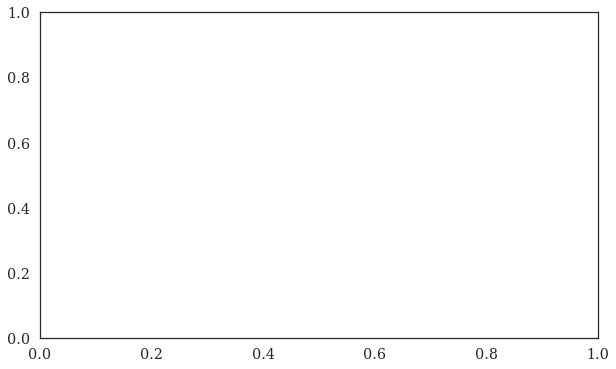

In [17]:
plt.figure(figsize=(10,6))
plt.plot(ttrain[1:train_window+1], x_train[0,:,0])
plt.plot(ttrain[:train_window], x_train[0,:,1], linewidth = 3)
plt.scatter(ttrain[train_window], y_train[0], color = 'k')
plt.plot(ttrain[:train_window + 1], ytrain[:train_window + 1], 'k--')
plt.legend(['Input excitation', 'Past output passed as input', 
           'Actual output', 'Next time step'], loc = 'best')
plt.show()

In [18]:
import torch.nn as nn
import torch.optim as optim

# Here we define our model as a class
class LSTM(nn.Module):
 
    def __init__(self, input_dim, hidden_dim, batch_size, output_dim=1,
                    num_layers=2):
        super(LSTM, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.batch_size = batch_size
        self.num_layers = num_layers
 
        # Define the LSTM layer
        self.lstm = nn.LSTM(self.input_dim, self.hidden_dim, self.num_layers)
 
        # Define the output layer
        self.linear = nn.Linear(self.hidden_dim, output_dim)
 
    def init_hidden(self):
        # This is what we'll initialise our hidden state as
        return (torch.zeros(self.num_layers, self.batch_size, self.hidden_dim),
                torch.zeros(self.num_layers, self.batch_size, self.hidden_dim))
 
    def forward(self, input):
        # Forward pass through LSTM layer
        # shape of lstm_out: [input_size, batch_size, hidden_dim]
        # shape of self.hidden: (a, b), where a and b both 
        # have shape (num_layers, batch_size, hidden_dim).
        lstm_out, self.hidden = self.lstm(input.view(len(input), self.batch_size, -1))
        
        # Only take the output from the final timetep
        # Can pass on the entirety of lstm_out to the next layer if it is a seq2seq prediction
        y_pred = self.linear(lstm_out[-1].view(self.batch_size, -1))
        return y_pred.view(-1)
 


In [26]:
model = LSTM(
    input_dim=2,
    hidden_dim=30,
    num_layers = 6,
    batch_size = x_train.shape[1]
    )

In [27]:
optimiser = torch.optim.Adam(model.parameters(), lr=1e-4)
loss_fn = torch.nn.MSELoss(size_average=False)
#####################
# Train model
#####################
num_epochs = 50000
hist = np.zeros(num_epochs)
 
for t in range(num_epochs):
    # Clear stored gradient
    model.zero_grad()
    
    # Initialise hidden state
    # Don't do this if you want your LSTM to be stateful
    model.hidden = model.init_hidden()
    
    # Forward pass
    y_pred = model(x_train)
 
    loss = loss_fn(y_pred, y_train)
    if t % 2 == 0:
        print("Epoch ", t, "MSE: ", loss.item())
    hist[t] = loss.item()
 
    # Zero out gradient, else they will accumulate between epochs
    optimiser.zero_grad()
 
    # Backward pass
    loss.backward()
 
    # Update parameters
    optimiser.step()

Epoch  0 MSE:  8345.833984375
Epoch  2 MSE:  8291.4189453125
Epoch  4 MSE:  8242.0615234375
Epoch  6 MSE:  8197.828125
Epoch  8 MSE:  8158.7451171875
Epoch  10 MSE:  8124.76904296875
Epoch  12 MSE:  8095.80908203125
Epoch  14 MSE:  8071.66162109375
Epoch  16 MSE:  8052.0615234375
Epoch  18 MSE:  8036.6904296875
Epoch  20 MSE:  8025.1240234375
Epoch  22 MSE:  8016.90478515625
Epoch  24 MSE:  8011.48291015625
Epoch  26 MSE:  8008.3466796875
Epoch  28 MSE:  8006.9208984375
Epoch  30 MSE:  8006.669921875
Epoch  32 MSE:  8007.1455078125
Epoch  34 MSE:  8007.96240234375
Epoch  36 MSE:  8008.79833984375
Epoch  38 MSE:  8009.46923828125
Epoch  40 MSE:  8009.85595703125
Epoch  42 MSE:  8009.9521484375
Epoch  44 MSE:  8009.7861328125
Epoch  46 MSE:  8009.40625
Epoch  48 MSE:  8008.9072265625
Epoch  50 MSE:  8008.375
Epoch  52 MSE:  8007.8662109375
Epoch  54 MSE:  8007.4326171875
Epoch  56 MSE:  8007.08203125
Epoch  58 MSE:  8006.853515625
Epoch  60 MSE:  8006.7119140625
Epoch  62 MSE:  8006.6567

KeyboardInterrupt: 

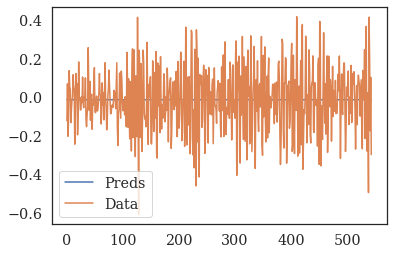

In [32]:
plt.plot(y_pred.detach().numpy(), label="Preds")
plt.plot(y_train.detach().numpy(), label="Data")
plt.legend()
plt.show()

In [86]:
new_seq

0

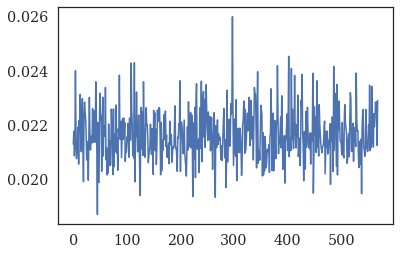

In [99]:
plt.figure()
plt.plot(np.array(preds))
#plt.plot(np.array(y_val), '--')
plt.show()

In [78]:
y_val.shape

torch.Size([569, 1])